In [12]:
import pandas as pd
import numpy as np
import cv2
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

In [3]:
IMG_SIZE = (2016*1512)

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
val_df = pd.read_csv('val.csv')
df_combined = pd.concat([train_df, test_df, val_df], ignore_index=True)

def count_class_prop(total_pixels, class_pixel_counts):
    class_prop = defaultdict(float)
    for cls, pixel_count in class_pixel_counts.items():
        class_prop[cls] = pixel_count / total_pixels
    return class_prop

def count_pixels(mask_paths):
	total_pixel = 0
	class_pixels = defaultdict(int)
	for mask_path in mask_paths:
			mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
			unique_classes, counts = np.unique(mask, return_counts=True)
			for cls, count in zip(unique_classes, counts):
					class_pixels[cls] += count
			total_pixel += IMG_SIZE
	return class_pixels, total_pixel

def count_img_pixel(mask_path):
	class_pixels = defaultdict(int)
	mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
	unique_classes, counts = np.unique(mask, return_counts=True)
	for cls, count in zip(unique_classes, counts):
			class_pixels[cls] += count
	return class_pixels


def plot_class_distribution(class_counts, title):
	plt.figure(figsize=(10, 6))
	plt.bar(class_counts.keys(), class_counts.values())
	plt.title(title)
	plt.xlabel('Class')
	plt.ylabel('Pixel Count')
	plt.xticks(list(class_counts.keys()))
	plt.grid(axis='y')
	plt.tight_layout()
	plt.show()


# Original dataset distribution

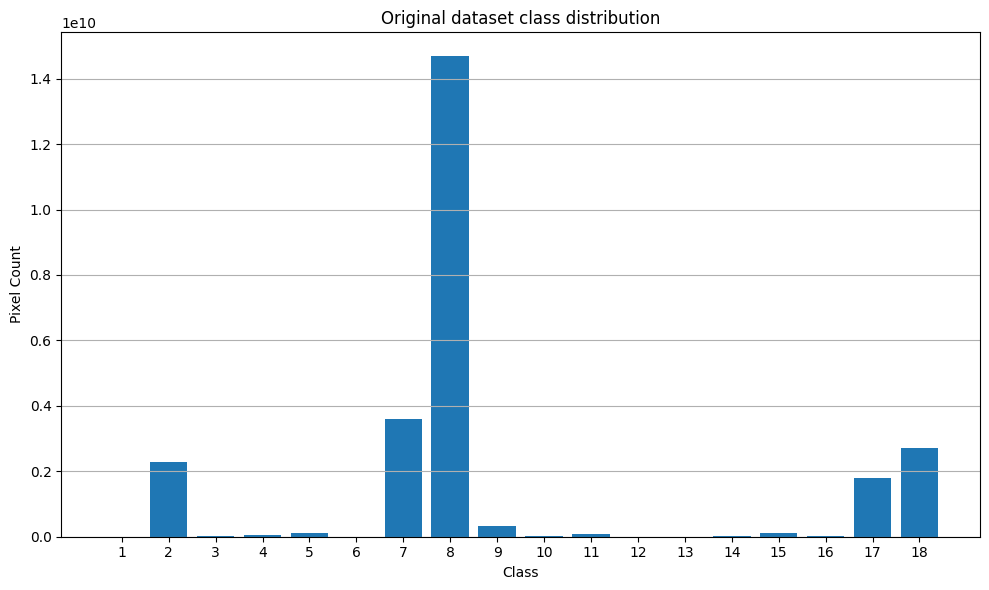

defaultdict(<class 'float'>, {2: 0.08797137528616451, 7: 0.13924377161251886, 8: 0.5688418854574638, 14: 0.0006244468589657123, 15: 0.004387032051559402, 17: 0.06918742413015463, 18: 0.10507720117259446, 11: 0.003571614018066316, 9: 0.012580414190771558, 16: 0.0010163980259906484, 3: 0.0005397336399138915, 4: 0.0022357706555407573, 12: 0.00013204678594299317, 5: 0.004027007873948775, 6: 0.00015503357513584894, 10: 0.0003948040044513913, 1: 4.938114388717196e-06, 13: 9.102546427661111e-06})


In [6]:
mask_list = df_combined['label_path'].tolist()
class_count, total_pixel = count_pixels(mask_list)
plot_class_distribution(class_count, 'Original dataset class distribution')
class_prop = count_class_prop(total_pixel, class_count)
print(class_prop)


# Sampling 30% of original dataset

In [109]:
def sample_images(df, pixel_counts_needed):
	# Calculate pixel counts per image for each class
	image_class_pixel_counts = {}

	for _, row in df.iterrows():
			mask_path = row['label_path']
			pixel_counts = count_img_pixel(mask_path)
			image_class_pixel_counts[row['id']] = pixel_counts

	sampled_images = []
	remaining_pixels_needed = pixel_counts_needed.copy()

	# Iterate through each class
	for cls in pixel_counts_needed:
		print("checking class: ", cls)
		needed_pixels = remaining_pixels_needed[cls]

		# Find images that contain the required class
		images_for_class = [(image_id, pixel_counts) 
												for image_id, pixel_counts in image_class_pixel_counts.items() 
												if cls in pixel_counts and pixel_counts[cls] > 0]
		images_for_class.sort(key=lambda x: x[1].get(cls, 0), reverse=True)

		for image_id, pixel_counts in images_for_class:
			if needed_pixels <= 0:
					print("All good for class: ", cls)
					break
			if image_id in df['id'].values:
				print("Adding: ", image_id)
				sampled_images.append(df[df['id'] == image_id].iloc[0])
	
				# Also update remaining pixels needed for all classes present in the image
				for c in pixel_counts:
						remaining_pixels_needed[c] -= pixel_counts.get(c, 0)
				
				needed_pixels -= pixel_counts.get(cls, 0)
				print("Remaining pixels: ", remaining_pixels_needed)

				# Stop if all pixel needs for the class are satisfied
			else:
				print("Image not in df")

		# Remove selected images from consideration
		df = df[~df['id'].isin([img['id'] for img in sampled_images])]

		# Exit loop if all class pixel requirements are met
		if all(remaining_pixels_needed[cls] <= 0 for cls in pixel_counts_needed):
				break

	# Check if we have met all pixel requirements
	for cls, remaining in remaining_pixels_needed.items():
			if remaining > 0:
					print(f"Warning: Not enough pixels for class {cls}. Remaining: {remaining}")

	return pd.DataFrame(sampled_images)

# Function test

In [110]:
df_testing = df_combined.sample(frac=0.10)
subset_test = int(0.01 * len(df_testing))
pixel_test_subset = subset_test * IMG_SIZE
subset_test_pixel = {}
for cls, prop in class_prop.items():
  subset_test_pixel[cls] = int(prop * pixel_test_subset)
sorted_test_subset = dict(sorted(subset_test_pixel.items(), key=lambda item:item[1]))
print(subset_test)
print(subset_test_pixel)
print(sum(subset_test_pixel.values())/IMG_SIZE)
print(sorted_test_subset)
print(len(df_testing))

8
{2: 2145229, 7: 3395534, 8: 13871514, 14: 15227, 15: 106980, 17: 1687172, 18: 2562363, 11: 87095, 9: 306780, 16: 24785, 3: 13161, 4: 54520, 12: 3220, 5: 98200, 6: 3780, 10: 9627, 1: 120, 13: 221}
7.9999973754934075
{1: 120, 13: 221, 12: 3220, 6: 3780, 10: 9627, 3: 13161, 14: 15227, 16: 24785, 4: 54520, 11: 87095, 5: 98200, 15: 106980, 9: 306780, 17: 1687172, 2: 2145229, 18: 2562363, 7: 3395534, 8: 13871514}
847


In [101]:
sample_df = sample_images(df_testing, pixel_counts_needed=sorted_test_subset)
sample_df.to_csv('test2.csv', index=False)

checking class:  1
Adding:  1624329338-066468760
Remaining pixels:  {1: -1362, 13: -1466, 12: 3220, 6: 3780, 10: -350, 3: 13161, 14: 14129, 16: 24103, 4: 54520, 11: 87095, 5: 98200, 15: 106980, 9: 306780, 17: 1094717, 2: 1903861, 18: 2509567, 7: 3126982, 8: 11993419}
Adding:  1624329294-784241751
Remaining pixels:  {1: -1399, 13: -1466, 12: 3220, 6: 3780, 10: -350, 3: 13161, 14: 14129, 16: 24103, 4: 54520, 11: 87095, 5: 98200, 15: 106980, 9: 124757, 17: 744606, 2: 1822890, 18: 2509567, 7: 2545152, 8: 10140199}
Adding:  1639437703-404278421
Remaining pixels:  {1: -1403, 13: -1466, 12: 3220, 6: 3780, 10: -350, 3: 10929, 14: 14129, 16: 23812, 4: 52922, 11: 84536, 5: 98200, 15: 106980, 9: 36407, 17: 7917, 2: 1791983, 18: 2307053, 7: 2499788, 8: 8202515}
checking class:  13
All good for class:  13
checking class:  12
Adding:  1639699719-973738688
Remaining pixels:  {1: -1403, 13: -1466, 12: -51375, 6: 3780, 10: -350, 3: 10929, 14: 14129, 16: 19537, 4: 52922, 11: 84536, 5: 98200, 15: 106980,

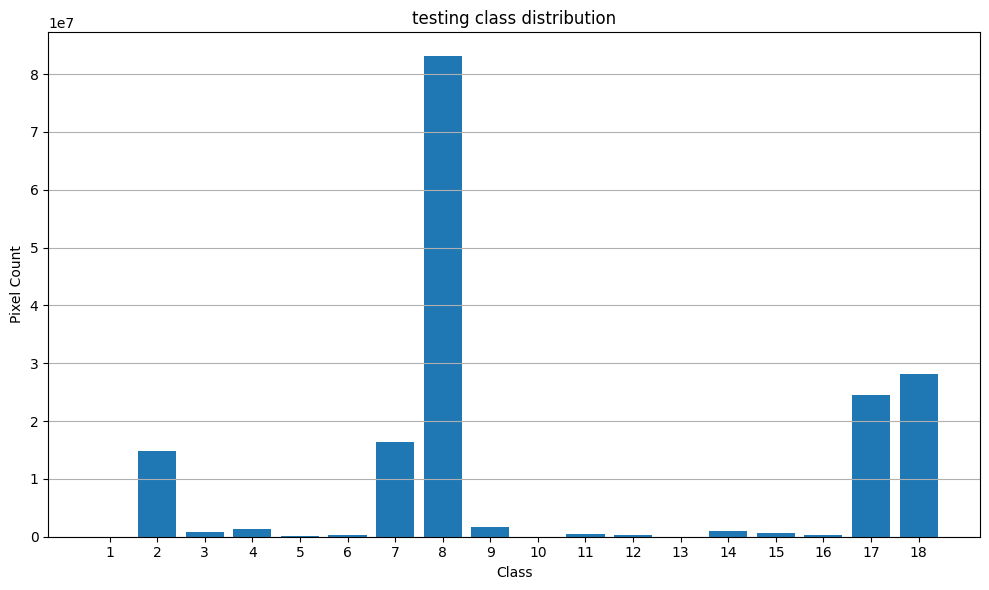

defaultdict(<class 'int'>, {1: 1523, 2: 14818701, 7: 16454416, 8: 83073958, 10: 9977, 13: 1687, 14: 933174, 16: 272388, 17: 24440632, 18: 28204347, 9: 1639727, 3: 879650, 4: 1297976, 11: 469547, 12: 263750, 15: 578742, 5: 128145, 6: 278604})
57


In [102]:
mask_list = sample_df['label_path'].tolist()
class_count, total_pixel = count_pixels(mask_list)
plot_class_distribution(class_count, 'testing class distribution')
class_test_prop = count_class_prop(total_pixel, class_count)
print(class_count)
print(len(sample_df))

# Selecting % of original dataset

In [117]:
sample_size = 0.25
subset = int(sample_size * len(df_combined))
pixel_subset = subset * IMG_SIZE
subset_class_pixel = {}
for cls, prop in class_prop.items():
  subset_class_pixel[cls] = int(prop * pixel_subset)
print(subset)
sorted_subset = dict(sorted(subset_class_pixel.items(), key=lambda item: item[1]))
print(sorted_subset)

2116
{1: 31850, 13: 58711, 12: 851698, 6: 999962, 10: 2546475, 3: 3481268, 14: 4027666, 16: 6555741, 4: 14420663, 11: 23036818, 5: 25974097, 15: 28296243, 9: 81143347, 17: 446257105, 2: 567413107, 18: 677745244, 7: 898118744, 8: 3669015526}


checking class:  1
Adding:  1624329352-539261257
Remaining pixels:  {1: -10816, 13: 46196, 12: 851698, 6: 999962, 10: 2506143, 3: 3481268, 14: 4027454, 16: 6522131, 4: 14420663, 11: 23036818, 5: 25974097, 15: 28292936, 9: 81098544, 17: 445703823, 2: 567132476, 18: 677639171, 7: 897727636, 8: 3667475873}
All good for class:  1
checking class:  13
Adding:  1624329434-212198800
Remaining pixels:  {1: -21616, 13: 21400, 12: 851698, 6: 999962, 10: 2467937, 3: 3481268, 14: 4027454, 16: 6485363, 4: 14420663, 11: 21131449, 5: 25974097, 15: 28292178, 9: 81089233, 17: 445679282, 2: 567130913, 18: 677557051, 7: 897570738, 8: 3666718811}
Adding:  1624329355-486793559
Remaining pixels:  {1: -21616, 13: -2365, 12: 851698, 6: 999962, 10: 2296657, 3: 3481268, 14: 4027454, 16: 6326172, 4: 14420663, 11: 21131449, 5: 25974097, 15: 28279386, 9: 81089233, 17: 445476212, 2: 566817691, 18: 677242240, 7: 897450333, 8: 3664989155}
All good for class:  13
checking class:  12
Adding:  1623372127-256644535
Remain

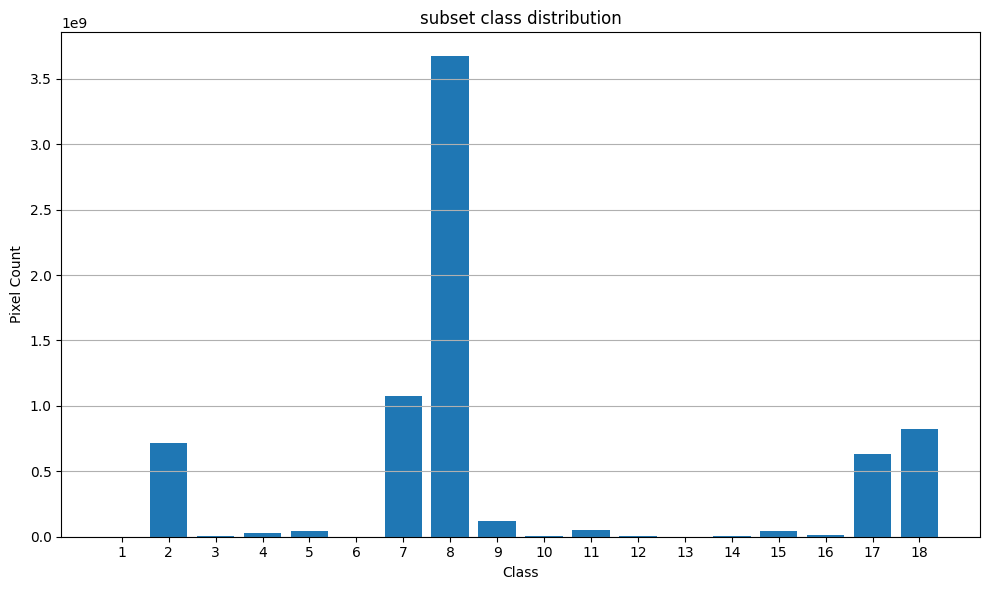

defaultdict(<class 'int'>, {1: 65199, 2: 718452798, 7: 1078886759, 8: 3670949894, 9: 119238020, 10: 4601363, 13: 109884, 14: 9046805, 15: 46312027, 16: 12626939, 17: 634714677, 18: 823274772, 11: 51313791, 12: 2424514, 4: 25958465, 6: 1212196, 3: 5988542, 5: 40375739})
2377


In [118]:
sample_df = sample_images(df_combined, pixel_counts_needed=sorted_subset)
sample_df.to_csv('subset.csv', index=False)

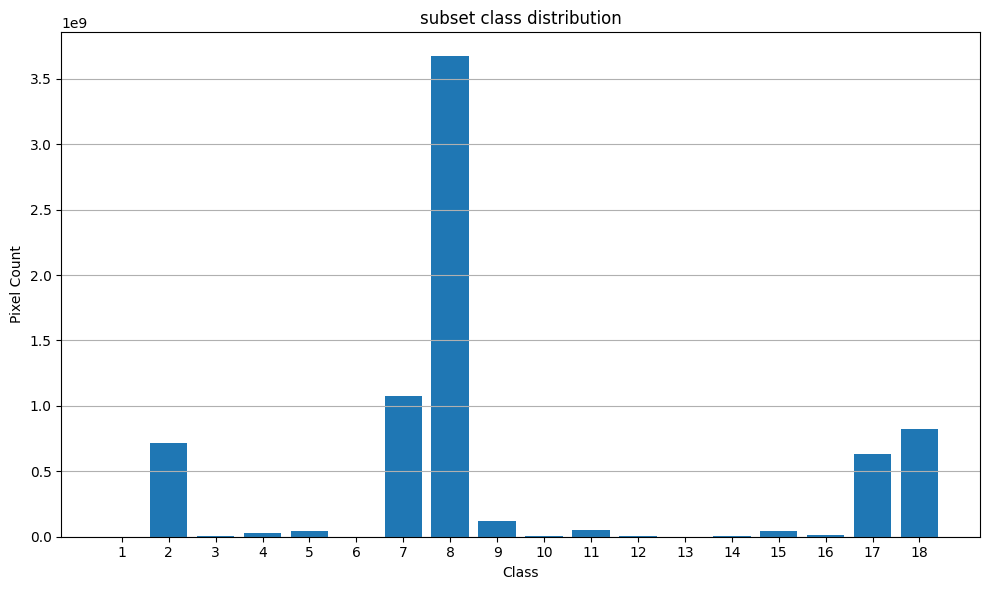

defaultdict(<class 'int'>, {1: 65199, 2: 718452798, 7: 1078886759, 8: 3670949894, 9: 119238020, 10: 4601363, 13: 109884, 14: 9046805, 15: 46312027, 16: 12626939, 17: 634714677, 18: 823274772, 11: 51313791, 12: 2424514, 4: 25958465, 6: 1212196, 3: 5988542, 5: 40375739})
2377


In [120]:
mask_list = sample_df['label_path'].tolist()
class_count, total_pixel = count_pixels(mask_list)
plot_class_distribution(class_count, 'subset class distribution')
class_subset_prop = count_class_prop(total_pixel, class_count)
print(class_count)
print(len(sample_df))

# Training Split

In [160]:
def sample_train_images(df, pixel_counts_needed, class_prop):
	# Calculate pixel counts per image for each class
	image_class_pixel_counts = {}

	for _, row in df.iterrows():
			mask_path = row['label_path']
			pixel_counts = count_img_pixel(mask_path)
			image_class_pixel_counts[row['id']] = pixel_counts

	sampled_images = []
	remaining_pixels_needed = pixel_counts_needed.copy()

	# Iterate through each class
	for cls in pixel_counts_needed:
		print("checking class: ", cls)
		needed_pixels = remaining_pixels_needed[cls]

		# Find images that contain the required class
		images_for_class = [(image_id, pixel_counts) 
												for image_id, pixel_counts in image_class_pixel_counts.items() 
												if cls in pixel_counts and pixel_counts[cls] > 0]
		images_for_class.sort(key=lambda x: x[1].get(cls, 0), reverse=True)

		for image_id, pixel_counts in images_for_class:
			if needed_pixels <= 0:
					print("All good for class: ", cls)
					break
			if image_id in df['id'].values:
				skip_image = False
				for c in pixel_counts:
					# handle rare classes
					if class_prop.get(c,0) < 0.001 and (remaining_pixels_needed.get(c,0) <= 0):
						print("Skipping image")
						skip_image = True
						break
				if skip_image:
					continue
				
				print("Adding: ", image_id)
				sampled_images.append(df[df['id'] == image_id].iloc[0])
	
				# Also update remaining pixels needed for all classes present in the image
				for c in pixel_counts:
						remaining_pixels_needed[c] -= pixel_counts.get(c, 0)
				
				needed_pixels -= pixel_counts.get(cls, 0)
				print("Remaining pixels: ", remaining_pixels_needed)

				# Stop if all pixel needs for the class are satisfied
			else:
				print("Image not in df")

		# Remove selected images from consideration
		df = df[~df['id'].isin([img['id'] for img in sampled_images])]

		# Exit loop if all class pixel requirements are met
		if all(remaining_pixels_needed[cls] <= 0 for cls in pixel_counts_needed):
				break

	# Check if we have met all pixel requirements
	for cls, remaining in remaining_pixels_needed.items():
			if remaining > 0:
					print(f"Warning: Not enough pixels for class {cls}. Remaining: {remaining}")

	return pd.DataFrame(sampled_images)

In [162]:
sample_size = 0.70
train_size = int(sample_size * len(sample_df))
pixel_train = train_size * IMG_SIZE
train_class_pixel = {}
for cls, prop in class_subset_prop.items():
  train_class_pixel[cls] = int(prop * pixel_train)
print(train_size)
print(class_prop)
print(train_class_pixel)
sorted_train_subset = dict(sorted(train_class_pixel.items(), key=lambda item: item[1]))
print(sum(sorted_train_subset.values())/IMG_SIZE)

1663
defaultdict(<class 'float'>, {2: 0.08797137528616451, 7: 0.13924377161251886, 8: 0.5688418854574638, 14: 0.0006244468589657123, 15: 0.004387032051559402, 17: 0.06918742413015463, 18: 0.10507720117259446, 11: 0.003571614018066316, 9: 0.012580414190771558, 16: 0.0010163980259906484, 3: 0.0005397336399138915, 4: 0.0022357706555407573, 12: 0.00013204678594299317, 5: 0.004027007873948775, 6: 0.00015503357513584894, 10: 0.0003948040044513913, 1: 4.938114388717196e-06, 13: 9.102546427661111e-06})
{1: 49006, 2: 557625436, 7: 682870530, 8: 2477406703, 9: 103674687, 10: 3930740, 13: 76652, 14: 8023720, 15: 40246063, 16: 9772928, 17: 481673173, 18: 592455993, 11: 44144010, 12: 2069049, 4: 22871797, 6: 855545, 3: 5386393, 5: 36010863}
1662.9999973754934


In [172]:
train_df = sample_train_images(sample_df, pixel_counts_needed=sorted_train_subset,class_prop=class_subset_prop)
train_df.to_csv('train_set.csv', index=False)

checking class:  1
Adding:  1624329352-539261257
Remaining pixels:  {1: 6340, 13: 64137, 6: 855545, 12: 2069049, 10: 3890408, 3: 5386393, 14: 8023508, 16: 9739318, 4: 22871797, 5: 36010863, 15: 40242756, 11: 44144010, 9: 103629884, 17: 481119891, 2: 557344805, 18: 592349920, 7: 682479422, 8: 2475867050}
Adding:  1624329431-733183381
Remaining pixels:  {1: -5390, 13: 64137, 6: 855545, 12: 2069049, 10: 3890408, 3: 5386393, 14: 8023508, 16: 9513895, 4: 22871797, 5: 36010863, 15: 40242756, 11: 43383158, 9: 103608621, 17: 481054040, 2: 557344805, 18: 592082640, 7: 682290125, 8: 2474360554}
All good for class:  1
checking class:  13
Skipping image
Adding:  1624329355-486793559
Remaining pixels:  {1: -5390, 13: 40372, 6: 855545, 12: 2069049, 10: 3719128, 3: 5386393, 14: 8023508, 16: 9354704, 4: 22871797, 5: 36010863, 15: 40229964, 11: 43383158, 9: 103608621, 17: 480850970, 2: 557031583, 18: 591767829, 7: 682169720, 8: 2472630898}
Adding:  1624329432-943595827
Remaining pixels:  {1: -5390, 13:

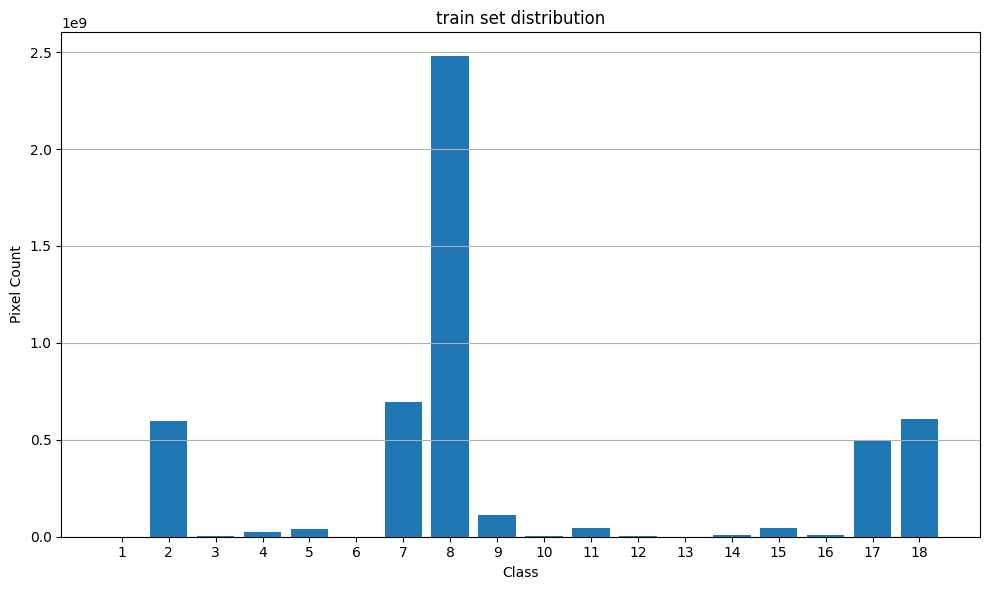

defaultdict(<class 'int'>, {1: 54396, 2: 596110484, 7: 697625728, 8: 2478406835, 9: 113086255, 10: 3964833, 13: 79996, 14: 8759644, 15: 43384411, 16: 9690483, 17: 492359947, 18: 608708955, 11: 46621541, 4: 24925415, 6: 1079823, 12: 2079643, 3: 5869904, 5: 39973531})
1697


In [173]:
mask_list = train_df['label_path'].tolist()
class_count, total_pixel = count_pixels(mask_list)
plot_class_distribution(class_count, 'train set distribution')
class_subset_prop = count_class_prop(total_pixel, class_count)
print(class_count)
print(len(train_df))

In [178]:
print(len(train_df)/len(sample_df))

0.7139251156920488


# Testing split

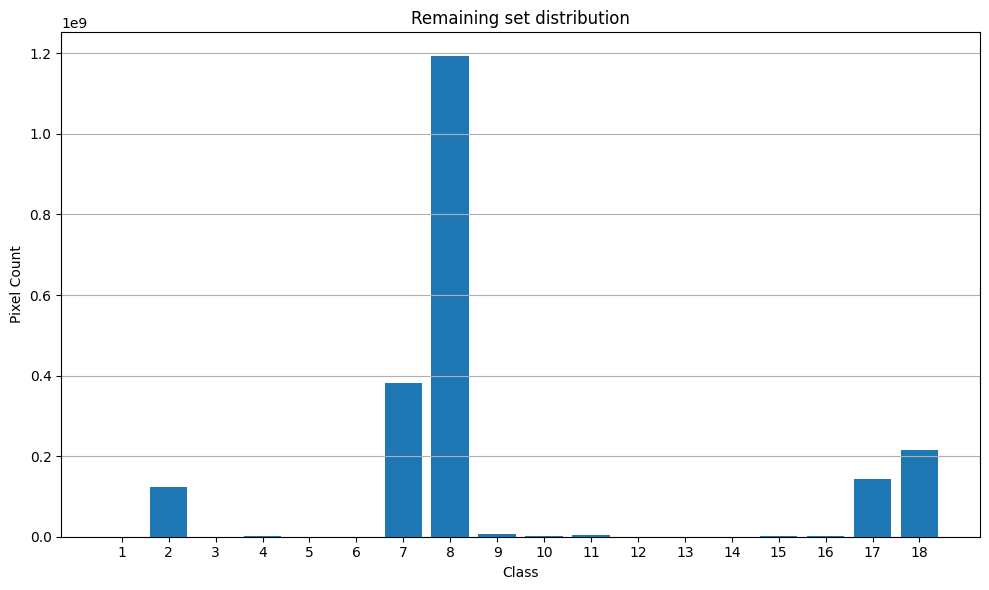

defaultdict(<class 'int'>, {1: 10803, 2: 122342314, 7: 381261031, 8: 1192543059, 9: 6151765, 10: 636530, 11: 4692250, 13: 29888, 15: 2927616, 16: 2936456, 17: 142354730, 18: 214565817, 12: 344871, 14: 287161, 6: 132373, 5: 402208, 3: 118638, 4: 1033050})


In [179]:
rem_df = sample_df[~sample_df['id'].isin(train_df['id'])]
mask_list = rem_df['label_path'].tolist()
class_count, total_pixel = count_pixels(mask_list)
plot_class_distribution(class_count, 'Remaining set distribution')
class_rem_prop = count_class_prop(total_pixel, class_count)
print(class_count)


In [180]:
sample_size = 0.70
test_size = int(sample_size * len(rem_df))
pixel_train = test_size * IMG_SIZE
test_class_pixel = {}
for cls, prop in class_rem_prop.items():
  test_class_pixel[cls] = int(prop * pixel_train)
print(test_size)
sorted_test_subset = dict(sorted(test_class_pixel.items(), key=lambda item: item[1]))
print(sum(sorted_test_subset.values())/IMG_SIZE)


475
474.99999639130345


In [181]:
test_df = sample_train_images(rem_df, pixel_counts_needed=sorted_test_subset,class_prop=class_rem_prop)
test_df.to_csv('test_set.csv', index=False)

checking class:  1
Adding:  1624329434-212198800
Remaining pixels:  {1: -3254, 13: -3919, 3: 82872, 6: 92466, 14: 200590, 12: 240902, 5: 280954, 10: 406428, 4: 721615, 15: 2044267, 16: 2014432, 11: 1372305, 9: 4287877, 2: 85458141, 17: 99414424, 18: 149798413, 7: 266165145, 8: 832269339}
All good for class:  1
checking class:  13
All good for class:  13
checking class:  3
Adding:  1639441000-483010654
Remaining pixels:  {1: -3254, 13: -3919, 3: 4328, 6: 92464, 14: 200590, 12: 240902, 5: 280954, 10: 406428, 4: 593045, 15: 2026477, 16: 2014432, 11: 1372305, 9: 4287877, 2: 84490811, 17: 99408706, 18: 149745991, 7: 265758686, 8: 830877982}
Adding:  1639441160-597153492
Remaining pixels:  {1: -3254, 13: -3919, 3: -26347, 6: 92464, 14: 200590, 12: 240902, 5: 280954, 10: 406428, 4: 593045, 15: 2018225, 16: 2014432, 11: 1372305, 9: 4287877, 2: 83767213, 17: 99379144, 18: 149728089, 7: 264818937, 8: 829579528}
All good for class:  3
checking class:  6
Adding:  1639434810-044995852
Remaining pix

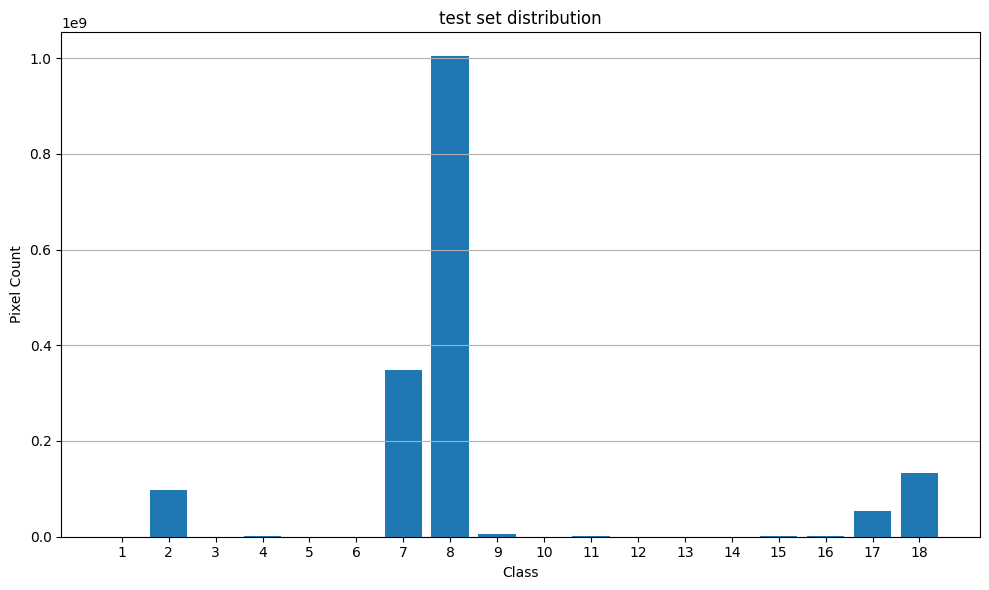

defaultdict(<class 'int'>, {1: 10800, 2: 97505455, 7: 348604972, 8: 1003584366, 9: 5305148, 10: 439931, 11: 2290199, 13: 24796, 15: 2265407, 16: 1264719, 17: 52809582, 18: 133566052, 3: 109219, 4: 728819, 6: 100930, 14: 213910, 5: 1210, 12: 246357})
541


In [185]:
mask_list = test_df['label_path'].tolist()
class_count, total_pixel = count_pixels(mask_list)
plot_class_distribution(class_count, 'test set distribution')
class_test_prop = count_class_prop(total_pixel, class_count)
print(class_count)
print(len(test_df))

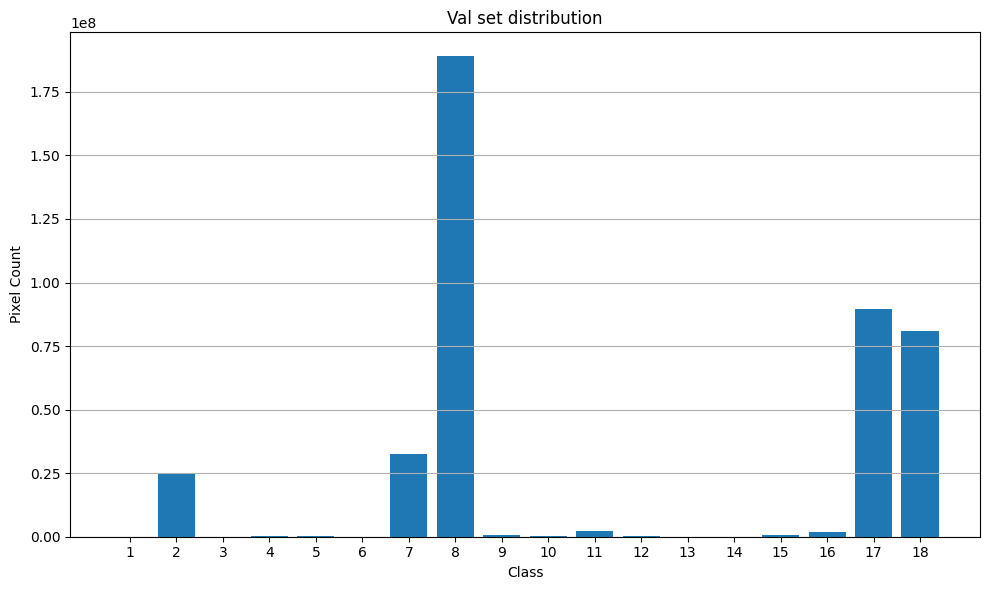

defaultdict(<class 'int'>, {7: 32656059, 8: 188958693, 10: 196599, 11: 2402051, 13: 5092, 16: 1671737, 17: 89545148, 18: 80999765, 2: 24836859, 14: 73251, 15: 662209, 12: 98514, 6: 31443, 9: 846617, 5: 400998, 1: 3, 4: 304231, 3: 9419})


In [195]:
test_train_df = pd.concat([train_df, test_df], ignore_index=True)
val_df = sample_df[~sample_df['id'].isin(test_train_df['id'])]
mask_list = val_df['label_path'].tolist()
class_count, total_pixel = count_pixels(mask_list)
plot_class_distribution(class_count, 'Val set distribution')
class_rem_prop = count_class_prop(total_pixel, class_count)
print(class_count)
val_df.to_csv('val_set.csv', index=False)

# Split proportion

In [197]:
print("% of original dataset selected: ", ((len(sample_df))/len(df_combined))*100)
print("train set: ", ((len(train_df))/len(sample_df))*100)
print("test set: ", ((len(test_df))/len(sample_df))*100)
print("val set: ", ((len(val_df))/len(sample_df))*100)


% of original dataset selected:  28.073697885910004
train set:  71.39251156920487
test set:  22.759781236853176
val set:  5.847707193941944
99.99999999999999
